Si ModuleNotFoundError: No module named 'tqdm' ou 'GPUtil' faire !pip install ... dans une cellule code

In [1]:
import os
import numpy as np
import joblib
import cv2

import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import time
import GPUtil
import psutil

In [2]:
CHECKPOINT_DIR = "chekpoints_ORB"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [3]:
UPSCALE_TO = 96
N_FEATURES = 500
VOCAB_SIZE = 300
KMEANS_BATCH = 4096
RANDOM_STATE = 42

In [4]:
class PerformanceTracker:
    def __init__(self):
        self.start_time = None
        self.logs = {}

    def start(self, name):
        self.start_time = time.time()
        self.cpu_start = psutil.cpu_percent(interval=None)
        self.mem_start = psutil.virtual_memory().used

    def stop(self, name):
        elapsed = time.time() - self.start_time
        cpu = psutil.cpu_percent(interval=None)
        mem = psutil.virtual_memory().used
        self.logs[name] = {
            "time_sec": elapsed,
            "cpu_percent": cpu,
            "ram_mb": mem / 1024**2
        }
        print(f"[{name}] Time: {elapsed:.1f}s | CPU: {cpu}% | RAM: {mem/1024**2:.0f} MB")

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [6]:
x_train_u8 = x_train.astype(np.uint8)
x_test_u8  = x_test.astype(np.uint8)

def preprocess_for_orb(img_u8, upscale_to=96):
    if upscale_to is not None and upscale_to != img_u8.shape[0]:
        img_u8 = cv2.resize(img_u8, (upscale_to, upscale_to), interpolation=cv2.INTER_CUBIC)
    return img_u8
orb = cv2.ORB_create(nfeatures=N_FEATURES)

In [7]:
def extract_orb_desc_from_array(images_u8, upscale_to=96, max_images=None):
    desc_list = []
    valid_idx = []

    n = len(images_u8) if max_images is None else min(len(images_u8), max_images)

    for i in range(n):
        img = preprocess_for_orb(images_u8[i], upscale_to=upscale_to)
        kp, desc = orb.detectAndCompute(img, None)
        if desc is None or len(desc) == 0:
            continue
        desc_list.append(desc)   # (n_kp, 32)
        valid_idx.append(i)

    return desc_list, np.array(valid_idx, dtype=np.int32)


In [8]:
tracker = PerformanceTracker()

tracker.start("ORB extraction (train+test)")
train_desc_list, train_valid_idx = extract_orb_desc_from_array(x_train_u8, upscale_to=UPSCALE_TO)
test_desc_list,  test_valid_idx  = extract_orb_desc_from_array(x_test_u8,  upscale_to=UPSCALE_TO)
tracker.stop("ORB extraction (train+test)")
y_train_f = y_train[train_valid_idx]
y_test_f  = y_test[test_valid_idx]


[ORB extraction (train+test)] Time: 33.8s | CPU: 20.6% | RAM: 7374 MB


In [9]:
all_train_desc = np.vstack(train_desc_list).astype(np.float32)  # (N_total_kp, 32)
print("Total train descriptors:", all_train_desc.shape)

kmeans = MiniBatchKMeans(
    n_clusters=VOCAB_SIZE,
    batch_size=KMEANS_BATCH,
    random_state=42,
    n_init="auto"
)

tracker.start("KMeans vocab")
kmeans.fit(all_train_desc)
tracker.stop("KMeans vocab")

joblib.dump(kmeans, os.path.join(CHECKPOINT_DIR, "kmeans_vocab_mnist.pkl"))
print("Saved vocab to:", os.path.join(CHECKPOINT_DIR, "kmeans_vocab_mnist.pkl"))


Total train descriptors: (1024077, 32)
[KMeans vocab] Time: 4.7s | CPU: 43.4% | RAM: 7075 MB
Saved vocab to: chekpoints_ORB\kmeans_vocab_mnist.pkl


In [10]:
def bovw_histograms(desc_list, kmeans, vocab_size):
    X = np.zeros((len(desc_list), vocab_size), dtype=np.float32)

    for i, desc in enumerate(desc_list):
        words = kmeans.predict(desc.astype(np.float32))
        hist = np.bincount(words, minlength=vocab_size).astype(np.float32)

        # Normalisation L2 (souvent mieux pour SVM)
        norm = np.linalg.norm(hist) + 1e-12
        X[i] = hist / norm

    return X


tracker.start("BoVW histograms")
X_train = bovw_histograms(train_desc_list, kmeans, VOCAB_SIZE)
X_test  = bovw_histograms(test_desc_list,  kmeans, VOCAB_SIZE)
tracker.stop("BoVW histograms")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

[BoVW histograms] Time: 12.7s | CPU: 23.3% | RAM: 7153 MB
X_train: (59815, 300)
X_test : (9971, 300)


In [11]:
svm = LinearSVC(dual="auto", random_state=42)
tracker.start("SVM training")
svm.fit(X_train, y_train_f)
tracker.stop("SVM training")

joblib.dump(svm, os.path.join(CHECKPOINT_DIR, "svm_bovw_orb_mnist.pkl"))
print("Saved SVM to:", os.path.join(CHECKPOINT_DIR, "svm_bovw_orb_mnist.pkl"))



[SVM training] Time: 3.5s | CPU: 24.0% | RAM: 7166 MB
Saved SVM to: chekpoints_ORB\svm_bovw_orb_mnist.pkl


In [12]:
y_pred = svm.predict(X_test)

acc = accuracy_score(y_test_f, y_pred)
print("Accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test_f, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test_f, y_pred))

Accuracy: 0.6323337679269883

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       966
           1       0.78      0.95      0.86      1121
           2       0.54      0.43      0.48      1031
           3       0.65      0.72      0.68      1010
           4       0.58      0.52      0.54       982
           5       0.55      0.59      0.57       892
           6       0.62      0.59      0.61       958
           7       0.64      0.49      0.55      1028
           8       0.65      0.69      0.67       974
           9       0.61      0.57      0.59      1009

    accuracy                           0.63      9971
   macro avg       0.62      0.63      0.62      9971
weighted avg       0.63      0.63      0.63      9971


Confusion matrix:
[[ 716  105   42    8   16   14   21   34    7    3]
 [  34 1065    3    4    0    6    0    7    1    1]
 [ 113   67  447   79   32   35   46  111   78   23]
 [  27    

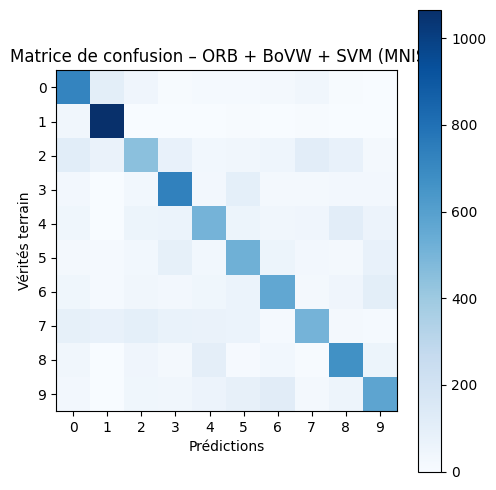

In [13]:
cm = confusion_matrix(y_test_f, y_pred)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matrice de confusion – ORB + BoVW + SVM (MNIST)")
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.colorbar()

# MNIST : classes = chiffres 0 à 9
classes = list(range(10))
plt.xticks(classes, classes)
plt.yticks(classes, classes)

plt.tight_layout()
plt.show()

### Conclusion

L’application de la méthode ORB combinée au Bag of Visual Words et à un SVM sur le jeu de données MNIST a permis de tester une approche générique sur un problème de reconnaissance de chiffres manuscrits. Toutefois, ce jeu de données, composé d’images simples, centrées et peu texturées, se prête mal à l’utilisation de descripteurs locaux comme ORB.

Les points clés détectés sont peu nombreux et parfois peu informatifs, ce qui limite fortement la qualité de la représentation BoVW. Par ailleurs, le coût de calcul lié à l’extraction des descripteurs et au clustering reste non négligeable sur CPU, sans apporter de réel avantage par rapport à des méthodes plus simples.

Dans ce contexte, cette approche apparaît surdimensionnée et inefficace pour MNIST.